In [2]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from utils import clear_data, encode_data, conf_matrix, evaluate_metrics, add_sessions

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("data/train_users_processed.csv")
test_data = pd.read_csv("data/test_users.csv")

sessions = pd.read_csv("data/sessions_processed.csv")
sessions = sessions.rename(columns={"user_id": "id"})

data = add_sessions(data, sessions)

In [4]:
cat_type = CategoricalDtype(data["country_destination"].unique(), ordered=True)
y = data["country_destination"].astype(cat_type).cat.codes

X = data.drop(["id", 
               "date_account_created", 
               "timestamp_first_active", 
               "country_destination", 
               "language",
               "first_browser",
               "signup_flow"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cat_features = [0] + list(range(2, 8))
train_pool = Pool(X, label=y, cat_features=cat_features)

In [7]:
cv_data = cv(params={"loss_function": "MultiClass", 
                     "eval_metric": "Accuracy",
                     "use_best_model": True},
             iterations=100,
             pool=train_pool,
             fold_count=5,
             shuffle=True,
             plot=True,
             stratified=True,
             verbose=False,
             return_models=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6482348352
bestIteration = 80

Training on fold [1/5]

bestTest = 0.6490393993
bestIteration = 98

Training on fold [2/5]

bestTest = 0.6467217711
bestIteration = 90

Training on fold [3/5]

bestTest = 0.6475263941
bestIteration = 96

Training on fold [4/5]

bestTest = 0.6484502646
bestIteration = 86



In [8]:
model_cat = cv_data[1][1]

Accuracy: 0.6418208860605173
Precision: 0.15927594239611634
Recall: 0.11343094907192752
F1: 0.1066131489144998


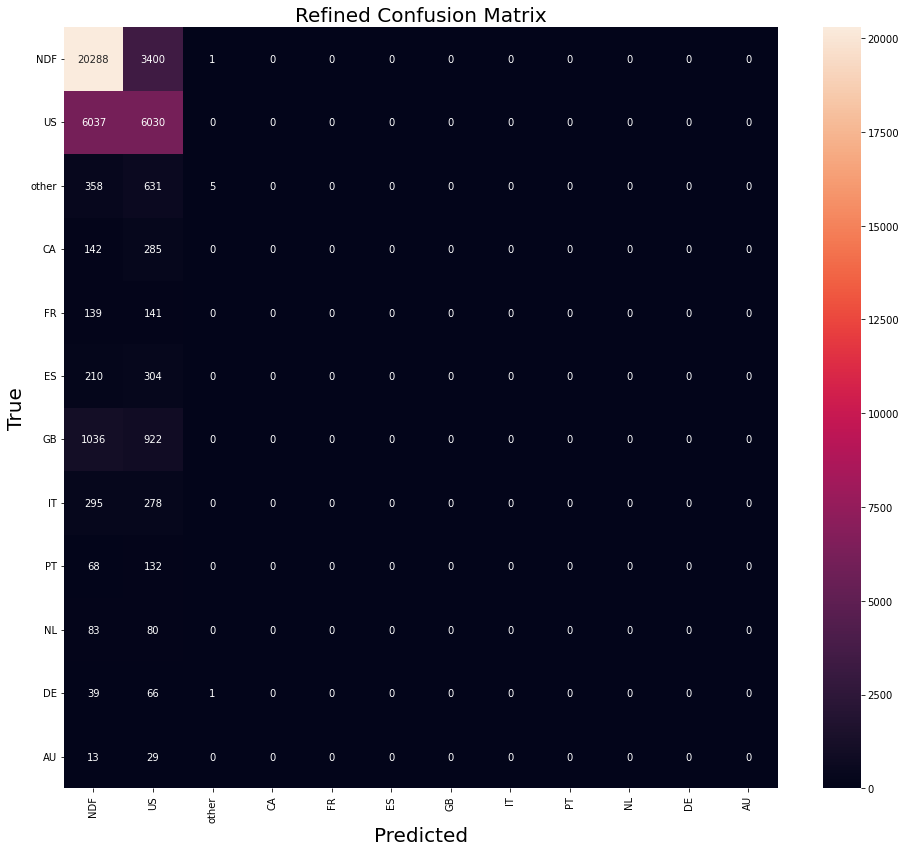

In [10]:
y_pred_cat = model_cat.predict(X_test)
y_pred_cat = y_pred_cat.argmax(axis=1)

accuracy = accuracy_score(y_test, y_pred_cat)
precision = precision_score(y_test, y_pred_cat, average="macro")
recall = recall_score(y_test, y_pred_cat, average="macro")
f1_score = f1_score(y_test, y_pred_cat, average="macro")

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1_score}")

conf_matrix(y_test, y_pred_cat)